本篇主要是对dreamer数据集进行一定的简单分析和拟合

结果并不是特别好，在随机森留一法情况下，所有人的平均准确率为0.52

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
path = '/home/wlgls/Desktop/DEAP/dreamer'

In [2]:
# 根据存储的文件在进行读取
def load_dreamer(path, subject=0):
    path = path+"/d{}.pkl"
    subjectList = np.array(('01','02','03','04','05','06','07','08',
               '09','10','11','12','13','14','15','16',
               '17','18','19','20','21','22','23'))
    with open(path.format(subjectList[subject]), "rb") as f:
        data = pickle.load(f)
    return data['baseline'], data['stimuli'], data['labels']

### 一、读取数据

以第一个人的数据为例，如下:

其中每一个受试者观看18个视频，每一个视频数据都主要包含一个基线数据，一个激励数据和标签数据。

其中：

基线和激励的形状都是18*1，每一个都是一个视频数据

labels主要包含Valence评分，Arousal评分，Domiance评分

In [3]:
baseline, stimuli, labels =load_dreamer(path)

In [4]:
baseline.shape, stimuli.shape, labels.shape

((18, 1), (18, 1), (18, 3))

### 二、视频数据分析

对于dreamer提供的eeg数据，采样频率为128Hz。

一共使用了14个通道。如下: {'AF3''F7''FC5''FC5''T7''P7''O1'''O2''P8''T8''FC6'F4''F8''AF4'}

受试者观看18个视频的基线是相同的都是61s。

但是在观看视频时，每个视频的时长并不相同，获取的脑也不相同。每一个视频的长度如下:

In [5]:
for i in range(18):
    vi_stimuli = stimuli[i, 0]
    print("第 {} 个视频的脑数据形状： {}, 时长为：{}s".format(i+1, vi_stimuli.shape, vi_stimuli.shape[-1]//128))

第 1 个视频的脑数据形状： (14, 25472), 时长为：199s
第 2 个视频的脑数据形状： (14, 16768), 时长为：131s
第 3 个视频的脑数据形状： (14, 44544), 时长为：348s
第 4 个视频的脑数据形状： (14, 21248), 时长为：166s
第 5 个视频的脑数据形状： (14, 17408), 时长为：136s
第 6 个视频的脑数据形状： (14, 24320), 时长为：190s
第 7 个视频的脑数据形状： (14, 24576), 时长为：192s
第 8 个视频的脑数据形状： (14, 50432), 时长为：394s
第 9 个视频的脑数据形状： (14, 18560), 时长为：145s
第 10 个视频的脑数据形状： (14, 8576), 时长为：67s
第 11 个视频的脑数据形状： (14, 12288), 时长为：96s
第 12 个视频的脑数据形状： (14, 23168), 时长为：181s
第 13 个视频的脑数据形状： (14, 47104), 时长为：368s
第 14 个视频的脑数据形状： (14, 21760), 时长为：170s
第 15 个视频的脑数据形状： (14, 39424), 时长为：308s
第 16 个视频的脑数据形状： (14, 24960), 时长为：195s
第 17 个视频的脑数据形状： (14, 32768), 时长为：256s
第 18 个视频的脑数据形状： (14, 23808), 时长为：186s


In [6]:
# 获取受试者第一个视频的基线和激励
v1_baseline = baseline[0, 0]
v1_stimuli = stimuli[0, 0]

In [7]:
print("第一个视频的基线的shape:", v1_baseline.shape)
print("第一个视频激励的shape:", v1_stimuli.shape)

第一个视频的基线的shape: (14, 7808)
第一个视频激励的shape: (14, 25472)


### 三、标签数据分析

dreamer使用三维情绪模型，标签主要包含Valence评分，Arousal评分，Domiance评分

其中每一个标签分1\~5个等级。需要注意的是他是离散的分数，不像deap那样从1\~9的连续分数

本文主要分析Valence标签。

In [8]:
# 受试者1的valence标签
valence = labels[:, 0]
valence

array([4, 3, 5, 4, 4, 1, 5, 1, 1, 5, 4, 4, 4, 3, 2, 3, 1, 3], dtype=uint8)

使用盒图观看18影片的的标签分布。

只有一小部分的视频的打分是模棱两可的，也是有正面评价也有负向评价，大部分影片的评价都都大部分要么是正向要么是负向。

其中评价为负面的影片数量更多。通过盒图可以看出，大部分受试者偏向于打3这个分数。比如影片1，14，15，18这几个有1/4的人打了三分，其他的影片也多有这个现象

In [9]:
all_labels = []
for i in range(23):
    _, _, l = load_dreamer(path, subject=i)
    all_labels.append(l[:, 0])
all_labels = np.array(all_labels)

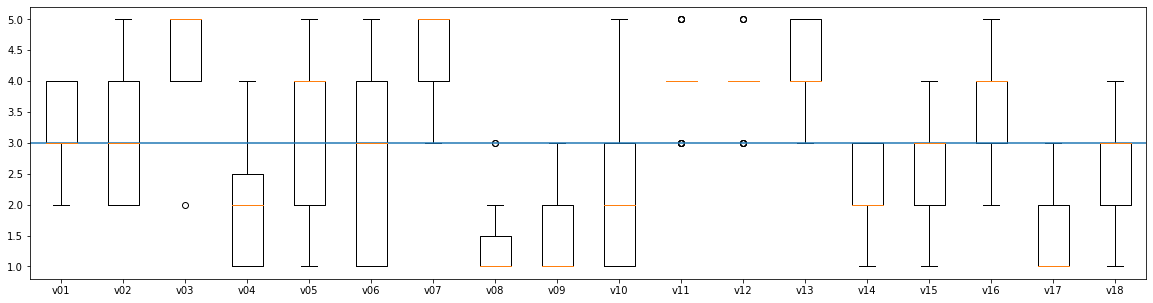

In [10]:
names = ('v01','v02','v03','v04','v05','v06','v07','v08',
               'v09','v10','v11','v12','v13','v14','v15','v16','v17','v18')
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(all_labels, 
           vert=True,
           labels=names)
ax.axhline(y=3)
plt.show()

### 3、实际测试

首先对一个受试者进行模型拟合。模型选择随机森林，留一法。

特征选择PSD特征

数据以1s窗口被切分

对于基线的处理，求解出61个特征后求取平均，然后使用数据减去

最后的分数选择投票法进行测试。


In [11]:
# 求解特征
def bin_power(data, band=(4, 8, 12, 16, 25, 45), fs=128):
    # 重构 批量化处理
    C = np.fft.fft(data)
    C = np.abs(C)
    power = []
    for b_index in range(len(band)-1):
        freq_s = float(band[b_index])
        freq_e = float(band[b_index+1])
        # 切分开始和结束
        start = int(np.floor(freq_s/fs*data.shape[-1]))
        end = int(np.floor(freq_e/fs*data.shape[-1]))
        power.append(np.sum(C[..., start:end], axis=-1))
    return np.stack(power, axis=-1)

# 切分数据
def split_signal(base, sti, lab, windows=1, fs=128):
    # print(b[0].shape, s[0].shape, l)
    bsp = base[0].shape[1]//fs//windows
    ssp = sti[0].shape[1]//fs//windows
    tmpb = np.stack(np.split(base[0], bsp, axis=1))
    tmps = np.stack(np.split(sti[0], ssp, axis=1))
    tmpl = np.repeat(lab, ssp)
    return tmpb, tmps, tmpl

# 将14个通道数据求解的特征拼接为1维
def combined_electrode(features):
    return features.reshape((*features.shape[:-2], -1))


# 标签二值化
def label_binarizer(label, threshold=3):
    # 打分为3认为是消极的
    tmp = np.copy(label)
    tmp[label<=threshold] = 0
    tmp[label> threshold] = 1
    return tmp

In [12]:
# 读取数据-受试者1
baseline, stimuli, labels =load_dreamer(path, subject=0)

In [13]:
# 分别对18个影片求解特征
for i, (b, s, l) in enumerate(zip(baseline, stimuli, labels[:, 0])):
    # 先切分数据
    tmpb, tmps, tmpl = split_signal(b, s, l)
    print("影片1切分后基线形状:", tmpb.shape)
    print("影片1切分后激励形状:", tmps.shape)
    print("影片1切分后标签形状:", tmpl.shape)
    print("-------")
    # 求解特征
    base_f = bin_power(tmpb)
    sti_f = bin_power(tmps)
    base_f = combined_electrode(base_f)
    sti_f = combined_electrode(sti_f)
    print("求解特征首基线形状:", base_f.shape)
    print("求解特征后激励形状:", sti_f.shape)
    print("-------")
    # 减去均值
    base_mu = np.mean(base_f, axis=0)[np.newaxis, :]
    x = sti_f - base_mu
    y = tmpl
    g = np.ones_like(y)*i # g用于在后续进行留一法测试
    print("最终的返回结果-数据:", x.shape)
    print("最终的返回结果-标签:", y.shape)
    print('g是什么：', g.shape, np.unique(g))
    break

影片1切分后基线形状: (61, 14, 128)
影片1切分后激励形状: (199, 14, 128)
影片1切分后标签形状: (199,)
-------
求解特征首基线形状: (61, 70)
求解特征后激励形状: (199, 70)
-------
最终的返回结果-数据: (199, 70)
最终的返回结果-标签: (199,)
g是什么： (199,) [0]


详细解释上述数据: 

基线为61\*14\*128，其中61表示基线一共有61s,共切出61个片段，每一个片段为14*128


同理，由于视频1的长度为199s,所以切出199个片段。标签的199表示将标签重复199次与影片1的199个片段对应以便后续的训练拟合。

In [14]:
# 做个函数，便于重复调用
def get_features(baseline, stimuli, labels, fe):
    X = []
    Y = []
    G = []

    for i, (b, s, l) in enumerate(zip(baseline, stimuli, labels[:, 0])):
        # 先切分数据
        tmpb, tmps, tmpl = split_signal(b, s, l)
        #print("影片1切分后基线形状:", tmpb.shape)
        #print("影片1切分后激励形状:", tmps.shape)
        #print("影片1切分后标签形状:", tmpl.shape)
        #print("-------")
        # 求解特征
        base_f = fe(tmpb)
        sti_f = fe(tmps)
        base_f = combined_electrode(base_f)
        sti_f = combined_electrode(sti_f)
        #print("求解特征首基线形状:", base_f.shape)
        #print("求解特征后激励形状:", sti_f.shape)
        #print("-------")
        # 减去均值
        base_mu = np.mean(base_f, axis=0)[np.newaxis, :]
        x = sti_f - base_mu
        y = tmpl
        g = np.ones_like(y)*i # g用于在后续进行留一法测试
        #print("最终的返回结果-数据:", x.shape)
        #print("最终的返回结果-标签:", y.shape)
        #print('g是什么：', g.shape, np.unique(g))
        G.append(g)
        X.append(x)
        Y.append(y)

    X = np.vstack(X)
    Y = np.concatenate(Y)
    G = np.concatenate(G)
    return X, Y, G

In [15]:
baseline, stimuli, labels =load_dreamer(path, subject=0)
X, Y, G = get_features(baseline, stimuli,labels, bin_power)
X.shape, Y.shape,G.shape

((3728, 70), (3728,), (3728,))

In [16]:
# 标签二值化
Y = label_binarizer(Y, threshold=3)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.base import clone

In [18]:
# 随机森林原始简洁版-受试者1
rfc = RandomForestClassifier(n_estimators=30, max_depth=20,random_state=42)
cv = LeaveOneGroupOut()
scores = cross_val_score(rfc, X, Y, cv=cv, groups=G)

In [19]:
print("直接计算的分数", np.mean(scores))
# 这里取个巧，因为如果对于某一个影片的分数是大于0.5的，说明有一半的数据被预测正确,那也就是直接正确了
print('投票分数:',np.mean(scores>=0.5))

直接计算的分数 0.5320142644928064
投票分数: 0.6111111111111112


In [21]:
# 对23个人全计算一遍
all_p = []
for i in range(23):
    b, s, l = load_dreamer(path, subject=i)
    X, Y, G = get_features(b, s ,l, bin_power)
    Y = label_binarizer(Y, threshold=3)
    rfc = RandomForestClassifier(n_estimators=30, max_depth=20,random_state=42)
    cv = LeaveOneGroupOut()
    # scores = cross_val_score(rfc, X, Y, cv=cv, groups=G)
    scores = []
    for index_train, index_test in cv.split(X, groups=G):
        rfc = clone(rfc)
        x_train, y_train = X[index_train], Y[index_train]
        x_test, y_test = X[index_test], Y[index_test]
        rfc.fit(x_train, y_train)
        scores.append(rfc.score(x_test, y_test))
    print("第 {} 个人的投票分数: {}".format(i+1, np.mean(np.array(scores)>=0.5)))
    all_p.append( np.mean(np.array(scores)>=0.5))
print("全部人平均分数：", np.mean(all_p))

第 1 个人的投票分数: 0.6111111111111112
第 2 个人的投票分数: 0.6111111111111112
第 3 个人的投票分数: 0.4444444444444444
第 4 个人的投票分数: 0.8888888888888888
第 5 个人的投票分数: 0.4444444444444444
第 6 个人的投票分数: 0.5555555555555556
第 7 个人的投票分数: 0.5555555555555556
第 8 个人的投票分数: 0.5555555555555556
第 9 个人的投票分数: 0.2777777777777778
第 10 个人的投票分数: 0.6111111111111112
第 11 个人的投票分数: 0.7222222222222222
第 12 个人的投票分数: 0.2777777777777778
第 13 个人的投票分数: 0.3333333333333333
第 14 个人的投票分数: 0.6666666666666666
第 15 个人的投票分数: 0.5555555555555556
第 16 个人的投票分数: 0.2777777777777778
第 17 个人的投票分数: 0.5
第 18 个人的投票分数: 0.2777777777777778
第 19 个人的投票分数: 0.5
第 20 个人的投票分数: 0.3333333333333333
第 21 个人的投票分数: 0.6111111111111112
第 22 个人的投票分数: 0.7777777777777778
第 23 个人的投票分数: 0.6111111111111112
全部人平均分数： 0.5217391304347827


In [22]:
from sklearn.svm import SVC

In [23]:
# 对23个人全计算一遍
all_p = []
for i in range(23):
    b, s, l = load_dreamer(path, subject=i)
    X, Y, G = get_features(b, s ,l, bin_power)
    Y = label_binarizer(Y, threshold=3)
    svc = SVC()
    cv = LeaveOneGroupOut()
    scores = cross_val_score(svc, X, Y, cv=cv, groups=G)
    print("第 {} 个人的投票分数: {}".format(i+1, np.mean(scores>=0.5)))
    all_p.append( np.mean(scores>=0.5))
print("全部人平均分数：", np.mean(all_p))

第 1 个人的投票分数: 0.16666666666666666
第 2 个人的投票分数: 0.6666666666666666
第 3 个人的投票分数: 0.5555555555555556
第 4 个人的投票分数: 0.7222222222222222
第 5 个人的投票分数: 0.5555555555555556
第 6 个人的投票分数: 0.6111111111111112
第 7 个人的投票分数: 0.6111111111111112
第 8 个人的投票分数: 0.5
第 9 个人的投票分数: 0.4444444444444444
第 10 个人的投票分数: 0.6666666666666666
第 11 个人的投票分数: 0.6111111111111112
第 12 个人的投票分数: 0.3888888888888889
第 13 个人的投票分数: 0.6666666666666666
第 14 个人的投票分数: 0.2222222222222222
第 15 个人的投票分数: 0.6111111111111112
第 16 个人的投票分数: 0.3888888888888889
第 17 个人的投票分数: 0.5
第 18 个人的投票分数: 0.3888888888888889
第 19 个人的投票分数: 0.6111111111111112
第 20 个人的投票分数: 0.6111111111111112
第 21 个人的投票分数: 0.6666666666666666
第 22 个人的投票分数: 0.5
第 23 个人的投票分数: 0.3333333333333333
全部人平均分数： 0.5217391304347826
